In [427]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import re
from sklearn.utils import resample, class_weight

Loading the data

In [431]:
Reviews = pd.read_csv("all_kindle_review.csv")
print(Reviews.head())

   Unnamed: 0.1  Unnamed: 0        asin  helpful  rating  \
0             0       11539  B0033UV8HI  [8, 10]       3   
1             1        5957  B002HJV4DE   [1, 1]       5   
2             2        9146  B002ZG96I4   [0, 0]       3   
3             3        7038  B002QHWOEU   [1, 3]       3   
4             4        1776  B001A06VJ8   [0, 1]       4   

                                          reviewText   reviewTime  \
0  Jace Rankin may be short, but he's nothing to ...   09 2, 2010   
1  Great short read.  I didn't want to put it dow...   10 8, 2013   
2  I'll start by saying this is the first of four...  04 11, 2014   
3  Aggie is Angela Lansbury who carries pocketboo...   07 5, 2014   
4  I did not expect this type of book to be in li...  12 31, 2012   

       reviewerID  reviewerName                   summary  unixReviewTime  
0  A3HHXRELK8BHQG        Ridley  Entertaining But Average      1283385600  
1  A2RGNZ0TRF578I  Holly Butler   Terrific menage scenes!      138119040

In [429]:
Reviews.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'asin', 'helpful', 'rating', 'reviewText',
       'reviewTime', 'reviewerID', 'reviewerName', 'summary',
       'unixReviewTime'],
      dtype='object')

In [430]:
Reviews=Reviews.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'asin',
       'reviewTime', 'reviewerID','unixReviewTime','reviewerName'] ,  axis=1)

In [432]:
Reviews.columns


Index(['Unnamed: 0.1', 'Unnamed: 0', 'asin', 'helpful', 'rating', 'reviewText',
       'reviewTime', 'reviewerID', 'reviewerName', 'summary',
       'unixReviewTime'],
      dtype='object')

In [433]:
Reviews.isnull().sum()

Unnamed: 0.1       0
Unnamed: 0         0
asin               0
helpful            0
rating             0
reviewText         0
reviewTime         0
reviewerID         0
reviewerName      38
summary            2
unixReviewTime     0
dtype: int64

In [434]:
Reviews.dropna(axis=0 , inplace=True)
Reviews.isnull().sum()

Unnamed: 0.1      0
Unnamed: 0        0
asin              0
helpful           0
rating            0
reviewText        0
reviewTime        0
reviewerID        0
reviewerName      0
summary           0
unixReviewTime    0
dtype: int64

Null Values problem solved..

In [435]:
print(Reviews.head())

   Unnamed: 0.1  Unnamed: 0        asin  helpful  rating  \
0             0       11539  B0033UV8HI  [8, 10]       3   
1             1        5957  B002HJV4DE   [1, 1]       5   
2             2        9146  B002ZG96I4   [0, 0]       3   
3             3        7038  B002QHWOEU   [1, 3]       3   
4             4        1776  B001A06VJ8   [0, 1]       4   

                                          reviewText   reviewTime  \
0  Jace Rankin may be short, but he's nothing to ...   09 2, 2010   
1  Great short read.  I didn't want to put it dow...   10 8, 2013   
2  I'll start by saying this is the first of four...  04 11, 2014   
3  Aggie is Angela Lansbury who carries pocketboo...   07 5, 2014   
4  I did not expect this type of book to be in li...  12 31, 2012   

       reviewerID  reviewerName                   summary  unixReviewTime  
0  A3HHXRELK8BHQG        Ridley  Entertaining But Average      1283385600  
1  A2RGNZ0TRF578I  Holly Butler   Terrific menage scenes!      138119040

In [436]:
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rponkam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [439]:
# --- ensure text column
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

if 'text' not in Reviews.columns:
    Reviews['summary'] = Reviews.get('summary', "").fillna("").astype(str).apply(clean_text)
    Reviews['reviewText'] = Reviews.get('reviewText', "").fillna("").astype(str).apply(clean_text)
    Reviews['text'] = (Reviews['summary'] + " . " + Reviews['reviewText']).str.strip()
else:
    Reviews['text'] = Reviews['text'].fillna("").astype(str).apply(clean_text)

# --- binary label: <=3 -> 0, else 1
def to_binary(r):
    try:
        r = float(r)
    except:
        return 0
    return 0 if r <= 3 else 1

Reviews['label'] = Reviews['rating'].apply(to_binary)
print("Raw class counts (overall):\n", Reviews['label'].value_counts())

# === Tokenize & pad
MAX_VOCAB = 30000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(Reviews['text'].tolist())
sequences = tokenizer.texts_to_sequences(Reviews['text'].tolist())
X_all = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y_all = Reviews['label'].values

# === Train/val/test split (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Train class counts before balancing:", np.bincount(y_train))

# === Upsample minority in training set to balance classes
def balance_upsample_binary(X, y, random_state=42):
    # X: numpy array, y: 1D label array of 0/1
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]
    if len(idx0) == len(idx1):
        return X, y
    # find minority
    if len(idx0) < len(idx1):
        idx_min, idx_maj = idx0, idx1
    else:
        idx_min, idx_maj = idx1, idx0
    # upsample minority to match majority
    upsampled_min = resample(idx_min, replace=True, n_samples=len(idx_maj), random_state=random_state)
    new_idxs = np.concatenate([idx_maj, upsampled_min])
    # shuffle
    perm = np.random.RandomState(random_state).permutation(len(new_idxs))
    new_idxs = new_idxs[perm]
    return X[new_idxs], y[new_idxs]

X_train_bal, y_train_bal = balance_upsample_binary(X_train, y_train, random_state=42)
print("Train class counts after balancing:", np.bincount(y_train_bal))

# === Model (Embedding + BiLSTM binary)
EMBED_DIM = 128
LSTM_UNITS = 128
DROPOUT = 0.3

model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)),
    Dropout(DROPOUT),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# === Callbacks & training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_rnn_binary.h5", monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=64,
    callbacks=callbacks
)

# === Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Val acc: {val_acc:.4f}, Test acc: {test_acc:.4f}")

# predictions (threshold 0.5)
y_pred_probs = model.predict(X_test, batch_size=128)
y_pred = (y_pred_probs.flatten() >= 0.5).astype(int)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['<=3 (0)','>3 (1)']))

Raw class counts (overall):
 label
0    5982
1    5978
Name: count, dtype: int64
Shapes: (9568, 200) (1196, 200) (1196, 200)
Train class counts before balancing: [4786 4782]
Train class counts after balancing: [4786 4786]


C:\Rakesh_DataScience\pythonproject\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.5785 - loss: 0.6761

150/150 ━━━━━━━━━━━━━━━━━━━━ 80s 514ms/step - accuracy: 0.6629 - loss: 0.6195 - val_accuracy: 0.7993 - val_loss: 0.4363
Epoch 2/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8554 - loss: 0.3520

150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 515ms/step - accuracy: 0.8669 - loss: 0.3332 - val_accuracy: 0.8545 - val_loss: 0.3545
Epoch 3/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 76s 506ms/step - accuracy: 0.9272 - loss: 0.2027 - val_accuracy: 0.8403 - val_loss: 0.3859
Epoch 4/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 511ms/step - accuracy: 0.9545 - loss: 0.1416 - val_accuracy: 0.8344 - val_loss: 0.4841
Epoch 5/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 75s 502ms/step - accuracy: 0.9694 - loss: 0.0904 - val_accuracy: 0.8227 - val_loss: 0.5466
Val acc: 0.8545, Test acc: 0.8319
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
Test accuracy: 0.8319397993311036
              precision    recall  f1-score   support

     <=3 (0)       0.83      0.83      0.83       598
      >3 (1)       0.83      0.83      0.83       598

    accuracy                           0.83      1196
   macro avg       0.83      0.83      0.83      1196
weighted avg       0.83      0.83      0.83      1196



In [440]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       598
           1       0.83      0.83      0.83       598

    accuracy                           0.83      1196
   macro avg       0.83      0.83      0.83      1196
weighted avg       0.83      0.83      0.83      1196



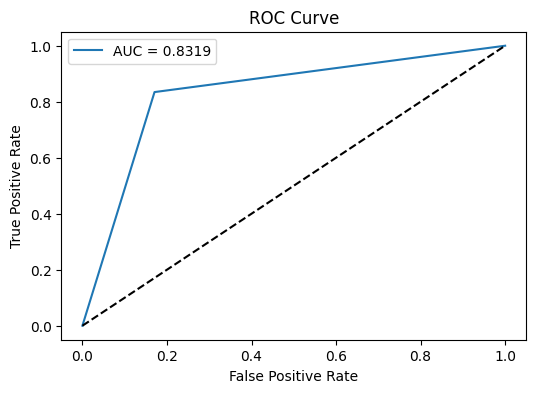

ROC-AUC: 0.8319397993311037


In [441]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC-AUC:", roc_auc)


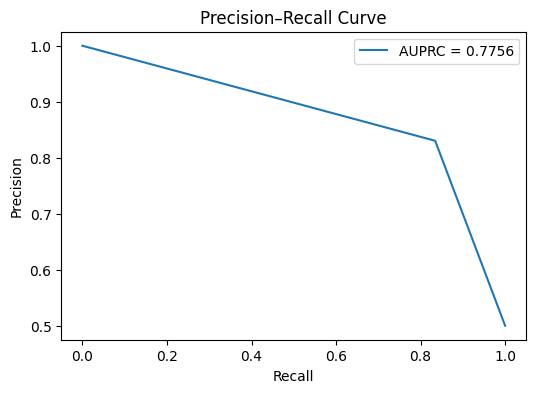

AUPRC: 0.7756039265660911


In [442]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"AUPRC = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

print("AUPRC:", ap)


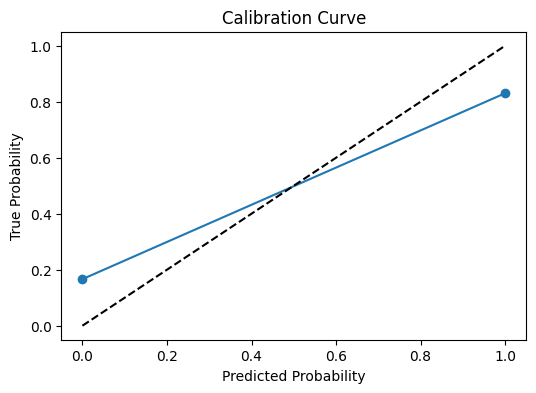

In [443]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()


In [444]:
# indices of wrong predictions
mis_idx = np.where(y_test != y_pred)[0]

print("Misclassified samples:", len(mis_idx))
for i in mis_idx[:20]:    # print first 20
    print("TRUE:", y_test[i], " PRED:", y_pred[i], " PROB:", y_pred_probs[i])
    print("TEXT:", tokenizer.sequences_to_texts([X_test[i]])[0])
    print("-"*60)


Misclassified samples: 201
TRUE: 0  PRED: 1  PROB: [0.6199921]
TEXT: wish fulfillment completely unrealistic and not in the oh my gosh that's too hot to be real way it's like something a middle aged woman would think of on her lunch break as an ideal romance now i am a middle aged woman but i'm not trying to pass my lunch break daydreams off as professional quality short stories anyway kayla thinks she's too old to find true love but her perfect hot and sensitive guy was right in front of her the whole time he thinks she's super sexy and he wants to be the perfect rough yet tender lover for her will his new job separate them the suspense isn't all that suspenseful and the sex scenes aren't very hot at all i'd skip this one <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OO